In [1]:
# import packages
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
from sklearn.metrics import pairwise_distances
import statsmodels.api as sm

## Read the data

In [2]:
# read sp-level abundance table
#path = '/Users/katerynapantiukh/Documents/1MyDisk/PhD/!MAIN_data/'
path = '/Users/ketpantuh/Documents/1MyDisk/PhD/!MAIN_data/' # home

abud = pd.read_csv(str(path)+'bgi_abud_tables/bgi_assembly_v1_SpLevel_RelAbund.csv')
# skip first row
abud = abud.iloc[1:]
abud.set_index('rep_MAG_ID', inplace=True)
abud = abud.T
abud.reset_index(inplace=True)

In [3]:
# read the phenotypes
import os
files = os.listdir(str(path)+'pheno/')
# remove hidden files
files = [file for file in files if not file.startswith('.')]
# remove first 5 characters from each file name
files = [file[6:] for file in files]
ph_list = [file[:-4] for file in files]

In [4]:
# drugs description
ph_names = pd.read_excel(str(path)+'pheno_description/phenotype_names.xlsx')
ph_names.head(2)

,code,name,type
0,B18,Chronic viral hepatitis,disease
1,B37,Candidiasis,disease


## Data preparation

In [5]:
# filter out sp with prevalence <1%
abud = abud.loc[:, abud.astype(bool).sum(axis=0) >= 21]
fspNumb = len(abud.columns)
perc = (len(abud)-fspNumb)/len(abud)*100

# Bonferoni correction
alpha = 0.05 / fspNumb

# how much columns starts from 'H" is at mrg?
print(f"Initial bacteria species count is {len(abud)}.")
print(f"Final sp. number after filtering is {fspNumb}.")
print(f"{str(perc)[0:5]}% of bacteria species were filtered out.")
print(f"Significance level after Bonferoni correction is {alpha}.")

Initial bacteria species count is 2101.
Final sp. number after filtering is 1595.
24.08% of bacteria species were filtered out.
Significance level after Bonferoni correction is 3.134796238244514e-05.


In [6]:
des = ph_names[ph_names['type'] == 'disease']['code'].to_list()
ph_des_sel = []

for ph_name in des:
    # read phenotype
    ph = pd.read_csv(str(path)+'/pheno/Pheno_'+ph_name+'.csv')
    if ph[ph_name].sum() > 100:
        # add value to list
        ph_des_sel.append(ph_name)

perc2 = (len(des)-len(ph_des_sel))/len(des)*100

print(f"Initial number of disease phenotype is {len(des)}.")
print(f"Number of phenotype with more then 100 cases is {len(ph_des_sel)}.")
print(f"{str(perc2)[0:5]}% of phenotypes were filtered out.")

Initial number of disease phenotype is 66.
Number of phenotype with more then 100 cases is 33.
50.0% of phenotypes were filtered out.


In [7]:
dr = ph_names[ph_names['type'] != 'disease']['code'].to_list()
ph_dr_sel = []

for ph_name in dr:
    # read phenotype
    ph = pd.read_csv(str(path)+'/pheno/Pheno_'+ph_name+'.csv')
    if ph[ph_name].sum() > 100:
        # add value to list
        ph_dr_sel.append(ph_name)

perc3 = (len(dr)-len(ph_dr_sel))/len(dr)*100

print(f"Initial number of drug phenotype is {len(dr)}.")
print(f"Number of phenotype with more then 100 cases is {len(ph_dr_sel)}.")
print(f"{str(perc3)[0:5]}% of phenotypes were filtered out.")

Initial number of drug phenotype is 132.
Number of phenotype with more then 100 cases is 1.
99.24% of phenotypes were filtered out.


## Start loop correlation analysis through the phenotypes

In [29]:
# phenotypes with more then 100 cases
nMore = []
# number of phenotypes with less then 100 cases
nLess = []

# Define your covariates
covariates = ['Age_at_MBsample', 'BMI', 'gender']
# create a new df for all correlation table
allCor = pd.DataFrame(columns=['pheno','bacteria', 'p-value', 'betta'])
# create a new df for aggregated results
res = pd.DataFrame(columns=['phenotype', 'ass_found', 'ass_bact','cases','controls'])

for ph_name in ph_des_sel:
    #reads phenotype data
    pheno = pd.read_csv(str(path)+'pheno/Pheno_'+str(ph_name)+'.csv')
    mrg = abud.merge(pheno, left_on='index', right_on='vkood', how='inner')

    # perform CLR transformation for columns with bacteria species
    tc = len(mrg.columns)-5
    mrg.iloc[:, 1:tc] = mrg.iloc[:, 1:tc].apply(lambda x: x/x.sum(), axis=1)

    if len(mrg[mrg[ph_name] == 1]) <100:
        nLess.append(ph_name)
    else:

        # fill NA values with mean
        mrg['BMI'].fillna(mrg['BMI'].mean(), inplace=True)
        mrg['gender'].fillna(mrg['gender'].mean(), inplace=True)
        mrg['Age_at_MBsample'].fillna(mrg['Age_at_MBsample'].mean(), inplace=True)

        # create a df with results for each phenotype
        df = pd.DataFrame(columns=['bacteria', 'p-value', 'betta'])

        n = len(mrg.columns)-5
        bac = mrg.columns[1:n]
        len(bac)

        for b in bac[0:2]:
            # Create a design matrix by adding the covariates to the model
            X = mrg[covariates + [b]]
            X = sm.add_constant(X)

            y = mrg[ph_name]

            # Fit the linear regression model
            #model = sm.OLS(y, X).fit()  
            # Fit the logistic regression model
            model = sm.Logit(y, X).fit()  

            # fill out separete table for phenotype
            rows_to_append = []
            new_row = {'bacteria': b, 'p-value': model.pvalues[b], 'betta': model.params[b]}
            rows_to_append.append(new_row)
            new_data = pd.DataFrame(rows_to_append)
            df = pd.concat([df, new_data], ignore_index=True)

            df.sort_values(by=['bacteria'], inplace=True)
            df.to_csv('results/corr_plot/Pval_'+str(ph_name)+'.csv', index=False)     

print(len(nMore))


Optimization terminated successfully.
         Current function value: 0.441307
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.441821
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365895
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365573
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.209181
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.208989
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.411241
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413192
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.508021
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.508219
  

/Users/ketpantuh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/ketpantuh/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


0


## Make a plot

In [10]:
# ??? ### read info about all bins
#path = '/Users/katerynapantiukh/Documents/1MyDisk/PhD/!MAIN_data/'
path = '/Users/ketpantuh/Documents/1MyDisk/PhD/!MAIN_data/' # home

ab = abud.T
rep = pd.read_excel(str(path)+'bgi_assembly_v1/HQcl_representative_MAGs_updated_v2.xlsx')
rep['bacteria'] = rep['rep_MAG_ID'].str.split('.').str[0]
rep = rep[['bacteria', 'phylum', 'class', 'order', 'family', 'genus', 'sp']]
rep = rep.merge(ab, left_on='bacteria', right_on='rep_MAG_ID', how='right')
len(rep)

2259

In [99]:
colors = {
        "Bacillota_A": '#70bb03',
        "Bacteroidota": '#00b1c4',
        "Bacillota": '#f26b58',
        "Pseudomonadota": '#f77189',
        "Cyanobacteriota": '#dc8932',
        "Actinomycetota": '#bb85cc',      
        "Verrucomicrobiota": '#ae9d31',     
        "Bacillota_C": '#d46eab',     
        "Desulfobacterota": '#3965c6',   
        "Campylobacterota": '#31b33e', 
        "Spirochaetota": '#33b07a',     
        "Bacillota_B": '#fcba03',      
        "Elusimicrobiota": '#36ada4',    
        "Fusobacteriota": '#996c4e',  
        "Synergistota": '#38a9c5',  
        "Myxococcota": '#3aa5df',     
        "Bacillota_G": '#6e9bf4',     
        "Eremiobacterota": '#a48cf4',    
        "Patescibacteria": '#cc7af4',  
        "Fibrobacterota": '#f45cf2'  
    }

In [13]:
path = '/Users/ketpantuh/Documents/1MyDisk/PhD/!MAIN_data/' # home

rep = pd.read_excel(str(path)+'bgi_assembly_v1/HQcl_representative_MAGs_updated_v2.xlsx')
ph = rep['phylum'].value_counts().to_frame()
ph['color'] = ph.index.map(colors)
ph

,phylum,color
Bacillota_A,1213,#70bb03
Bacteroidota,337,#00b1c4
Bacillota,212,#f26b58
Pseudomonadota,159,#f77189
Cyanobacteriota,78,#dc8932
Actinomycetota,70,#c39532
Verrucomicrobiota,58,#ae9d31
Bacillota_C,45,#97a431
Desulfobacterota,29,#3965c6
Campylobacterota,12,#31b33e


In [19]:
rep['bacteria'] = rep['rep_MAG_ID'].str.split('.').str[0]

# test
df = pd.read_csv('results/corr_plot/Pval_I25.csv')
df = df.merge(rep, left_on='bacteria', right_on='bacteria', how='left')

df = df.sort_values(by=['sp'], ascending=True).reset_index(drop=True)
df = df.sort_values(by=['genus'], ascending=True).reset_index(drop=True)
df = df.sort_values(by=['family'], ascending=True).reset_index(drop=True)
df = df.sort_values(by=['order'], ascending=True).reset_index(drop=True)
df = df.sort_values(by=['class'], ascending=True).reset_index(drop=True)
df = df.sort_values(by=['genus'], ascending=True).reset_index(drop=True)
df = df.sort_values(by=['phylum'], ascending=True).reset_index(drop=True)

# mapp colors to phylum
col = sns.color_palette("husl", 20)
col = col.as_hex()
col = dict(zip(rep['phylum'].unique(), col))
df['color'] = df['phylum'].map(col)

df.head(2)

,bacteria,p-value,rep_MAG_ID,cluster name,MAGs_per_cluster,genome_length,Completeness,Contamination,MAG_qual,num_seqs,...,present_at_UHGG,name,prevalence_by_mapping,perc_MAG,perc_mapping,5S_rRNA,16S_rRNA,23S_rRNA,Total_tRNA_Types,color
0,H2036_Collinsella_undS,0.567623,H2036_Collinsella_undS.fa,HQ-569_32,1,1867148,84.3,0.75,MQ,280,...,EstMAG_overlap,Collinsella undS,495,0.05%,21.93%,0,1,0,18,#31b33e
1,H2024_Collinsella_undS,0.080021,H2024_Collinsella_undS.fa,HQ-569_19,1,2042056,88.4,1.23,MQ,94,...,EstMAG_overlap,Collinsella undS,731,0.05%,32.39%,1,2,0,21,#31b33e


In [82]:
df.index

RangeIndex(start=0, stop=1594, step=1)

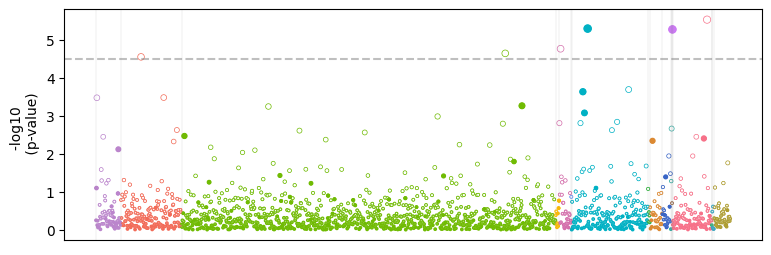

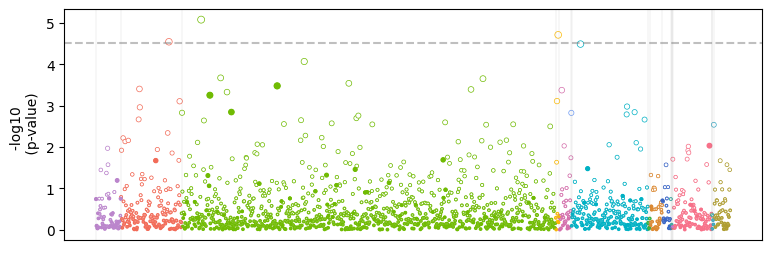

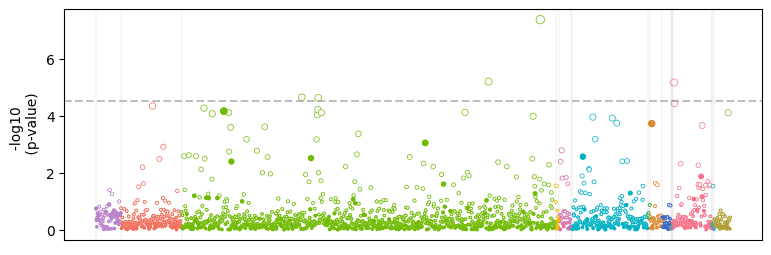

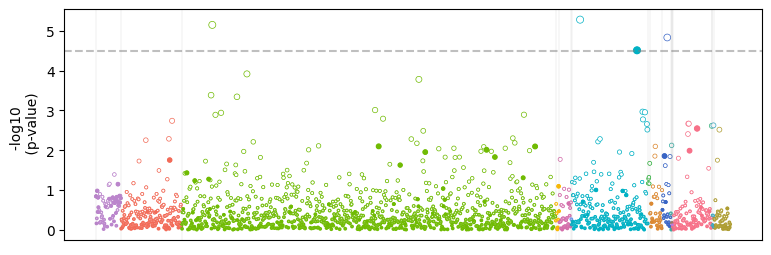

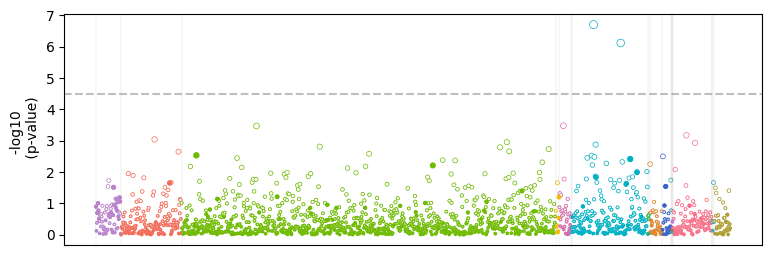

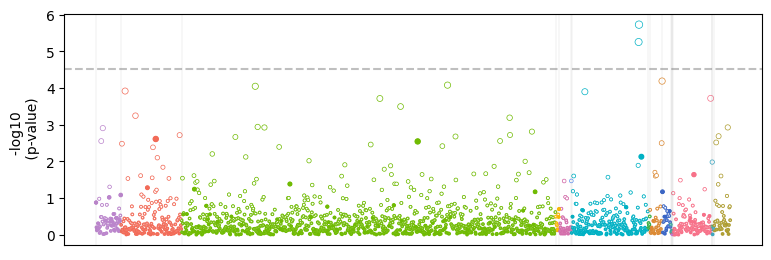

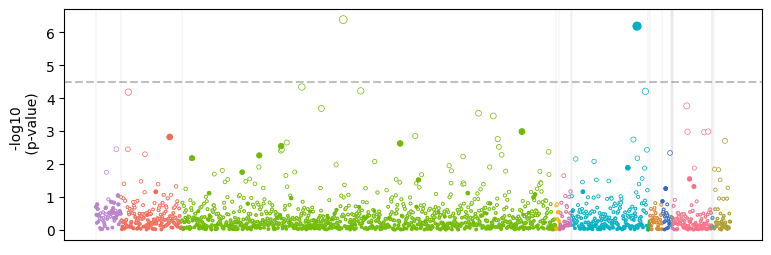

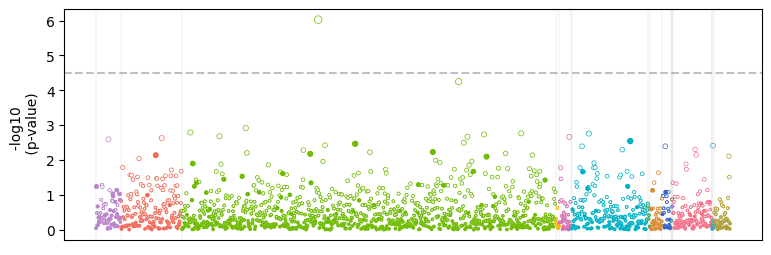

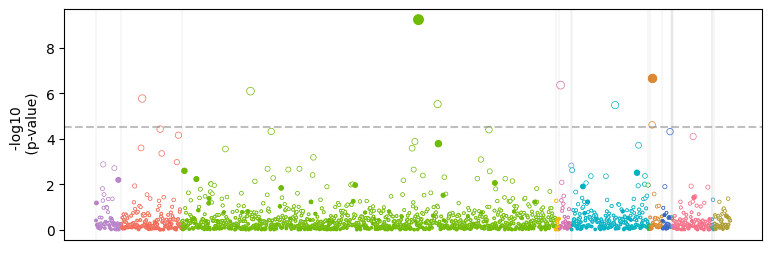

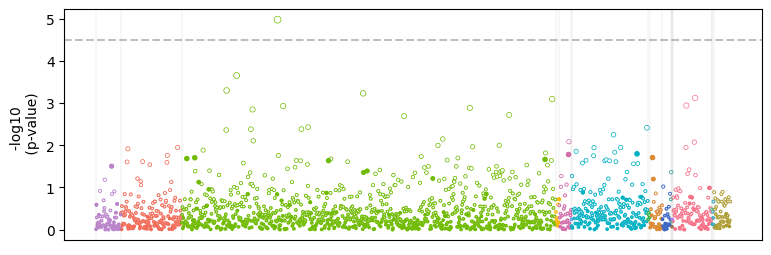

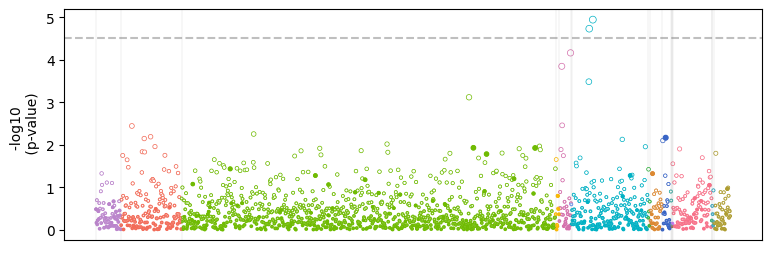

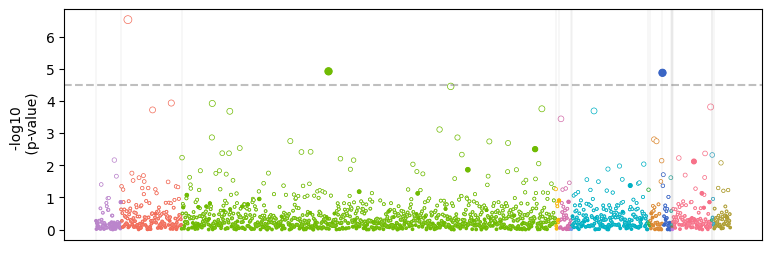

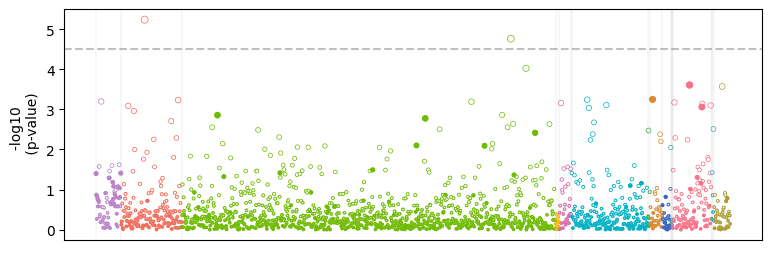

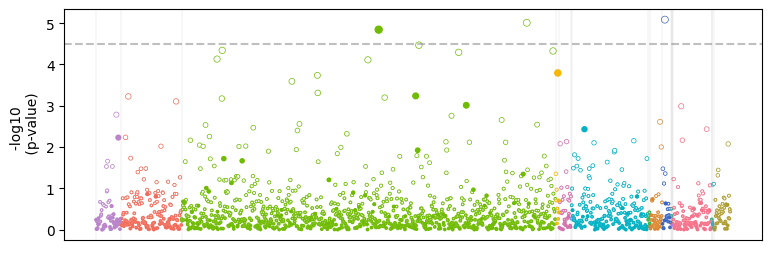

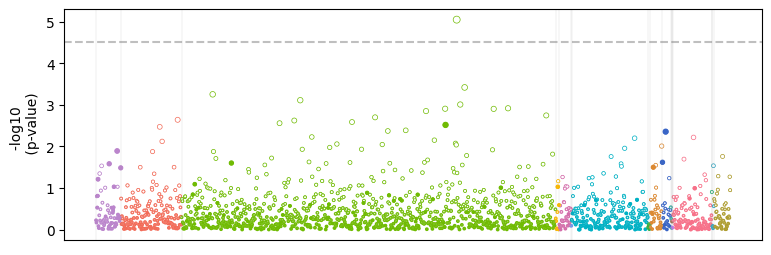

In [101]:
import numpy as np

pheno=['I25', 'D50', 'E55', 'F33', 'F41', 'G43', 'H40', 'I10', 'I50', 'J02', 'J30', 'J31', 'J45', 'K80', 'L70']
#pheno=['I25']

for ph in pheno:

    df = pd.read_csv('results/corr_plot/Pval_'+str(ph)+'.csv')
    df = df.merge(rep, left_on='bacteria', right_on='bacteria', how='left')

    # sort by taxa
    df = df.sort_values(by=['sp'], ascending=True).reset_index(drop=True)
    df = df.sort_values(by=['genus'], ascending=True).reset_index(drop=True)
    df = df.sort_values(by=['family'], ascending=True).reset_index(drop=True)
    df = df.sort_values(by=['order'], ascending=True).reset_index(drop=True)
    df = df.sort_values(by=['class'], ascending=True).reset_index(drop=True)
    df = df.sort_values(by=['genus'], ascending=True).reset_index(drop=True)
    df = df.sort_values(by=['phylum'], ascending=True).reset_index(drop=True)

    df['color'] = df['phylum'].map(colors)

    # Convert p-values to -log10(p-value) to emphasize smaller p-values
    df['minusLog10PValue'] = -np.log10(df['p-value'])
    df['point_size'] = np.log10(1 / df['p-value']) * 5 
    # pickup new sp.
    dfN = df[df['bacteria'].str.contains('undS')]

    plt.figure(figsize=(9, 3))
    plt.scatter(df.index, df['minusLog10PValue'], c=df['color'], s=3)
    plt.scatter(df.index, df['minusLog10PValue'], s=df['point_size'], color='white', edgecolors=df['color'], linewidth=0.5)
    plt.scatter(dfN.index, dfN['minusLog10PValue'], s=dfN['point_size'], color=dfN['color'])

    pl = df[['phylum', 'color']]
    pl = pl.drop_duplicates()

    for i in pl.index:
        plt.axvline(x=i, color='grey', alpha=0.9, linewidth=0.1)

    plt.axhline(y=-np.log10(alpha), color='grey', linestyle='--', alpha=0.5)
    plt.ylabel('-log10 \n (p-value)')
    #plt.title(ph, fontsize=15)
    #plt.xticks(pl.index, labels=[])
    plt.xticks([])
    plt.xlabel('')

    plt.savefig('results/corr_plot/mht'+str(ph)+'.png', dpi=300, bbox_inches='tight')
    plt.savefig('results/corr_plot/mht'+str(ph)+'.svg', bbox_inches='tight')